In [2]:
import graph_tool as gt
from graph_tool.draw import graph_draw
import graph_tool.collection
import graph_tool.generation as gen
import axelrod as axl
import pandas as pd
import toolz as tz
import numpy as np  
import matplotlib.pyplot as plt
from random import choice, sample
from copy import deepcopy
from collections import Counter
%matplotlib inline


In [3]:
# project params
outputPath = './sf.png'


In [103]:
# network params
N = _N = 1000
_m = 2
_c = 0 
_gamma = 1

# game params
_R=1
_P=0
_T=1.5 # T€[0,2] 
_S=-.5 # S€[-1,1]

# evo params
_episode_n = 100
_te = 1
_ta = 0.5
_W = _te/_ta
_beta = 0.05

In [502]:
'''Init''' 
C = 'C'
D = 'D'
def initStrats(N) = [choice([C,D]) for i in range(N)]
def initPayoffs(N) = [0 for i in range(N)]

'''Graph'''
def initGraph(N=_N, m=_m, c=_c, gamma=_gamma) = gen.price_network(N=N, m=m, c=c, gamma=gamma, directed=False)
def getNeighborIds(graph, id) = graph.vertex(id).out_neighbors() |> map$(int) |> list
def sampleNeighbor(graph, id) = choice(getNeighborIds(graph, id))
def sampleNeighborUnique(graph, id1, id2) = set(getNeighborIds(graph, id1)) - set(getNeighborIds(graph, id2)) - set([id2]) |> list |> choice
def isLonely(graph, x) = len(graph.get_all_edges(x)) == 1 #checks if node has only 1 edge
def rewireEdge(graph, x, y, z):
    _graph = graph
    _graph.remove_edge(_graph.edge(x,y))
#     print(f'adding {x},{z}')
    _graph.add_edge(x, z)
    return _graph
# neighbors of id1 eligible for rewiring id2 to 
def eligibleNewFriends(graph, id1, id2) = set(getNeighborIds(graph, id1)) - set(getNeighborIds(graph, id2)) - set([id2]) |> list
'''Games'''
def makeDilemma(R=_R, P=_P, T=_T, S=_S) = {C:{C:[R,R], D:[S,T]}, D:{C:[T,S], D:[P,P]}} # T€[0,2] S€[-1,1]
dilemma = makeDilemma()
# playDilemma :: [strat] -> id -> id -> float
def playDilemma(dilemma, strats, id1, id2) = dilemma[strats[id1]][strats[id2]]
# cumulativePayoffs :: graph -> [strat] # 1 round of all connections playing one another
def cumulativePayoffs(N, dilemma, graph, strats):
    payoffs = initPayoffs(N)
    idPlayDilemma = playDilemma$(dilemma, strats) 
    for [x,y] in graph.iter_edges():
        px,py = idPlayDilemma(x,y)
        payoffs[x] += px
        payoffs[y] += py
    return payoffs


In [501]:
'''Structural Update'''
def attemptRewire(graph, x, y):
    if isLonely(graph, x) or isLonely(graph, y): 
#         print(f'{x},{y} is lonely')
        return graph #enforcing graph connectedness
    _graph = graph
    eligible = eligibleNewFriends(_graph, y, x)
    if not eligible:
#         print(f'{x},{y} no one to switch to')
        return graph #enforcing graph connectedness
    return rewireEdge(graph, x, y, choice(eligible))
def updateTies(graph, strats, payoffs, x):
    y = sampleNeighbor(graph, x)
#     print(f'updating {x}({strats[x]}),{y}({strats[y]})')
    args = [[x,y], [y,x]]
    p = fermi(_beta, payoffs[x] - payoffs[y])        
    if (strats[x] == C and strats[y] == D):
        return attemptRewire(graph, x, y)
    elif (strats[x] == D and strats[y] == D):
        return  np.random.choice([0,1], p=[p, 1-p]) |> args[] |*> attemptRewire$(graph)
    return graph
    
'''Strategy Evolution'''
def fermi(beta, fitness_diff) = np.clip(1. / (1. + np.exp(beta * fitness_diff, dtype=np.float64)), 0., 1.)
def calcK(graph, x, y) = 
    def deg(z) = graph.vertex(z).out_degree()
    max(deg(x), deg(y))
def calcD(T=_T, S=_S) = max(T, 1) - min(S, 0)
def transProb(calcK, P, x, y) = (P[y] - P[x]) / (calcK(x, y) * calcD())
# updateStrat :: graph -> [strat] -> [float] -> id -> strat
def updateStrat(graph, strats, payoffs, x) = 
    _calcK = calcK$(graph)
    y = sampleNeighbor(graph, x)
#   p = transProb(_calcK, payoffs, x, y)
    p = fermi(_beta, payoffs[x] - payoffs[y])     
    strats[x] if payoffs[x] > payoffs[y] else np.random.choice([strats[y], strats[x]], p=[p, 1-p])
# updateStrat :: graph -> [strat] -> [float] -> [strat]
def updateStrats(N, graph, strats, payoffs):
    _strats = deepcopy(strats)
    for x in range(N):
        _strats[x] = updateStrat(graph, _strats, payoffs, x)
    return _strats
# chooses between structural and strat updates
def evoUpdate(N, graph, strats, payoffs): 
    _strats = deepcopy(strats)
    _graph = graph
    p = 1/(1+_W)
    for x in range(N):
        doStratUpdate = np.random.choice([True, False], p=[p, 1-p])
        if doStratUpdate:
            _strats[x] = updateStrat(graph, _strats, payoffs, x)
        else:
            _graph = updateTies(graph, _strats, payoffs, x)
    return _graph, _strats

In [503]:
# runEvolution :: int -> graph -> [strat] -> [float] -> [[strat]]
def runEvolution(N, episode_n, graph, strats, payoffs):
    episodes = [strats]
    totalPayoffs = initPayoffs(N)
    _strats = []
    for i in range(episode_n):
        payoffs = cumulativePayoffs(N, dilemma, graph, strats)
        _graph, _strats = evoUpdate(N, graph, strats, payoffs)
        episodes.append(deepcopy(_strats))
        totalPayoffs = np.add(totalPayoffs, payoffs)
        strats = _strats
        graph = _graph
    return graph, totalPayoffs, episodes

def runExperiment(N=_N, episode_n=_episode_n):
    strats = initStrats(N)
    totalPayoffs = initPayoffs(N)
    graph = initGraph(N=N)
    dilemma = makeDilemma(R=_R, P=_P, T=_T, S=_S)
    _graph, totalPayoffs, episodes = runEvolution(N, episode_n, dilemma, graph, strats, totalPayoffs)
    return (_graph, totalPayoffs, episodes)

In [6]:
# Plots
def drawGraph(graph) = graph_draw(graph, bg_color="white") 
def plotHist(_list, bins) = pd.Series(_list).hist(bins = bins)
def plotStratEvo(episodes) = pd.DataFrame([dict(Counter(ep)) for ep in episodes]).plot.line()

In [17]:
totalPayoffs, episodes = runExperiment()

In [498]:
graph, totalPayoffs, episodes = runExperiment(500,100)

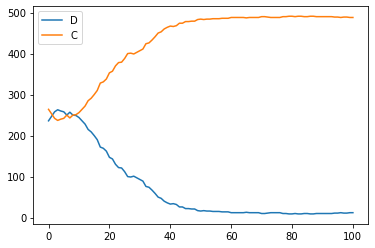

In [499]:
plotStratEvo(episodes)